# The impact of weather events using hurricane Sandy 


<img src="images/hurricane_sandy.png" width=600 height=400 />
https://www.tableau.com/solutions/gallery/storm-tracking



## Hypothesis
- H1.1: Cancellation explained through independed variables. Which variable influence it at most?
- H1.2 Diverted flights with destination choosen airports (Sergej)
- H2: There is a threshold (wind, rain, fog) until the flights are cancelled. Some kind of outliers, data pieks (Sergej)
- H3: The values are different one year before



- H3: Many delays up to two weeks after the hurricane.
- Show the course of hurricane Sandy
- Mark the airports with dates


## Get flights and weather data


## EDA + Visualization 
		cancelled
		delays
		diverted
- Add dates of hurricane Sandy: 


## Questions to answer and plot 
- Diverted flights with destination of the airports:
    - Boston (BOS)
	- Miami (MIA)
	- Newark (EWR)
	- New York (JFK)
	- Philadelphia (PHL)
	- Purto Rico (SJU)

# Download flights data from a website

In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2
import requests #package for getting data from the web
from zipfile import * #package for unzipping zip files
from sql import get_engine #adjust this as necessary to match your sql.py connection methods

In [3]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [6]:
years = [2011, 2012] # list of years you want to look at, specify one year
months = [10, 11, 12] # list of months you want to look at, specify one month
# Here: October, November, October 2011 and 2012 / 1 file ca. 23 mb

# Loop through months
for year in years:
    for month in months:
        # Get the file from the website https://transtats.bts.gov
        zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        csv_file = f'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv'
        url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
        # Download the database
        # r = requests.get(f'{url}', verify=False)
        # Save database to local file storage
        with open(path+zip_file, 'wb') as f:
            f.write(r.content)

NameError: name 'r' is not defined

In [ ]:
# Unzip your files (220Mb/per file)
for year in years:
    for month in months:
        zip_files = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        with ZipFile(path+zip_files, 'r') as zip_ref:
            zip_ref.extractall(path)

In [ ]:
# Read in your data DOESNT WORK YET
# df = pd.DataFrame(data=None)
# for year in years:
#     for month in months:
#         appended_flights = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv', low_memory = False)
#         df.append(appended_flights)

# pd.concat([all_df], axis=0)

SyntaxError: 'return' outside function (3463468356.py, line 7)

In [ ]:
# Read in your data
pd.concat([all_df], axis=0)
flights_df_2011_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_10.csv', low_memory = False)
flights_df_2011_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_11.csv', low_memory = False)
flights_df_2011_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_12.csv', low_memory = False)
flights_df_2012_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_10.csv', low_memory = False)
flights_df_2012_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_11.csv', low_memory = False)
flights_df_2012_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_12.csv', low_memory = False)
# Combine your date, use a function
flights_df1 = flights_df_2011_10.append(flights_df_2011_11)
flights_df2 = flights_df1.append(flights_df_2011_12)
flights_df3 = flights_df2.append(flights_df_2012_10)
flights_df4 = flights_df3.append(flights_df_2012_11)
df = flights_df4.append(flights_df_2012_12)

# 2. Prepare the csv file for further processing

In the next step, we clean and prepare our dataset.

a) Since the dataset consists of a lot of columns, we we define which ones to keep.

In [ ]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [ ]:
# set up your database connection
engine = get_engine()

In [ ]:
# The columns in the DB have different naming as in the source csv files. Lets get the names from the DB
table_name_sql = '''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='public'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [ ]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'distance',
 'cancelled',
 'diverted']

In [ ]:
# Just in case the above fails here are the results
new_column_names_alternate = ['flight_date',
                              'dep_time',
                              'sched_dep_time',
                              'dep_delay',
                              'arr_time',
                              'sched_arr_time',
                              'arr_delay',
                              'airline',
                              'tail_number',
                              'flight_number',
                              'origin',
                              'dest',
                              'air_time',
                              'distance',
                              'cancelled',
                              'diverted' ]

b) With the next function, we make our csv file ready to be uploaded to SQL.  
We only keep to above specified columns and convert the datatypes.

In [ ]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [ ]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


If you decide to only look at specific airports, it is a good decision to filter for them in advance.  
This function does the filtering. 

In [ ]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering airline df for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [ ]:
# Execute function, filtering for New York area airports
airports=['BOS', 'EWR', 'JFK', 'MIA', 'PHI', 'SJU']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


# 3. Push the prepared data to a table in the database

In [ ]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table
table_name = 'group4_flights_data'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This will take a minute or two...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

In [ ]:
# Check the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

True

# Get weather_data with API

In [1]:
# import python packages 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display

# import from own modules
import sql as gd
import api
from sql import get_conn

# change options
pd.set_option('display.max_columns', None)

In [ ]:
#api.get_weather_stations('US', 'data/us_weather_stations.csv')
#api.get_weather_stations('PR', 'data/pr_weather_stations.csv')

In [2]:
us_stations_df = pd.read_csv('data/us_weather_stations.csv')

# from https://www.faa.gov/airports/airport_safety/airportdata_5010/menu/#datadownloads
airports_df = pd.read_sql('SELECT * FROM airports_info', get_conn())

# filter only rows of the 6 airports we are interested in
locations = airports_df[airports_df['faa'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]

# create a list of icao ids of the location to pass to the API
icao_list = locations['icao'].tolist()

In [ ]:
# get all weather stations in us and puerto rico
# api.get_weather_stations('PR', 'data/pr_weather_stations.csv')

In [3]:
# find the weather stations near the 6 relevant airports
us_stations_df = pd.read_csv('data/us_weather_stations.csv')

# create dataframe of weather stations in Puerto Rico
pr_stations_df = pd.read_csv('data/pr_weather_stations.csv')

# create a dataframe of all weather stations in US and Puerto Rico
all_weather_stations_df = pd.concat([us_stations_df, pr_stations_df], axis=0)

# filter dataframe on the icao identifiers of the 6 airports
weather_stations_df = all_weather_stations_df[all_weather_stations_df['icao'].isin(icao_list)]
display(weather_stations_df)

,id,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
110,72202,Miami International Airport,US,FL,72202.0,KMIA,25.7833,-80.3167,4.0,America/New_York,1973-01-01,2021-11-04,1948-01-01,2021-11-01,1948-01-01,2021-01-01
266,72408,Philadelphia International Airport,US,PA,72408.0,KPHL,39.8667,-75.2333,6.0,America/New_York,1973-01-01,2021-11-04,1940-07-01,2021-11-01,1940-01-01,2021-01-01
336,72502,Newark Airport,US,NJ,72502.0,KEWR,40.6833,-74.0000,5.0,America/New_York,1973-01-01,2021-11-04,1893-01-01,2021-11-01,1893-01-01,2021-01-01
343,72509,Boston Logan International,US,MA,72509.0,KBOS,42.3667,-71.0167,6.0,America/New_York,1943-11-21,2021-11-04,1936-01-01,2021-11-01,1936-01-01,2021-01-01
532,74486,John F. Kennedy Airport,US,NY,74486.0,KJFK,40.6333,-73.7667,4.0,America/New_York,1973-01-01,2021-11-04,1948-07-17,2021-11-01,1948-01-01,2021-01-01
0,78526,"San Juan / Int., Puerto Rico",PR,NaN,78526.0,TJSJ,18.4333,-66.0000,3.0,America/Puerto_Rico,2005-01-01,2021-11-05,1941-06-17,2021-11-02,1941-01-01,2021-01-01


In [4]:
# in order to use lat and lon values I am going to create a dictionary with:
    # key = icao
    # values = latitude, longitude
stations_dict = dict()
for i in range(len(weather_stations_df)):
    key = weather_stations_df['icao'].iloc[i]
    stations_dict[key] = weather_stations_df['latitude'].iloc[i], weather_stations_df['longitude'].iloc[i]
    
display(stations_dict)

{'KMIA': (25.7833, -80.3167),
 'KPHL': (39.8667, -75.2333),
 'KEWR': (40.6833, -74.0),
 'KBOS': (42.3667, -71.0167),
 'KJFK': (40.6333, -73.7667),
 'TJSJ': (18.4333, -66.0)}

In [7]:
#start = dt.datetime(2012, 10, 1)
#end = dt.datetime(2012, 12, 31) 
#api.get_weather_daily(stations_dict, start, end, 'data/weather_2012_4quarter.csv')

,icao,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,,
2012-10-01,KMIA,26.7,24.4,28.3,45.0,NaN,NaN,10.8,NaN,1010.4,NaN
2012-10-02,KMIA,26.4,23.3,30.6,17.8,NaN,NaN,8.6,NaN,1014.4,NaN
2012-10-03,KMIA,28.3,24.4,32.2,3.6,NaN,NaN,11.2,NaN,1019.1,NaN
2012-10-04,KMIA,28.6,25.0,32.2,1.8,NaN,83.9,12.2,NaN,1019.8,NaN
2012-10-05,KMIA,29.0,26.7,31.7,0.3,NaN,80.0,12.6,NaN,1016.6,572.0
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,TJSJ,26.1,23.9,30.6,0.3,0.0,NaN,10.1,NaN,1015.7,NaN
2012-12-28,TJSJ,26.2,23.3,29.4,1.8,0.0,NaN,13.7,NaN,1016.2,NaN
2012-12-29,TJSJ,25.9,23.3,28.9,0.3,0.0,NaN,13.3,NaN,1016.6,NaN


In [7]:
#start = dt.datetime(2011, 10, 1)
#end = dt.datetime(2011, 12, 31) 
#api.get_weather_daily(stations_dict, start, end, 'data/weather_2011_4quarter.csv')

In [2]:
# Code	Meaning
# TEMP	Air Temperature
# TAVG	Average Temperature
# TMIN	Minimum Temperature
# TMAX	Maximum Temperature
# DWPT	Dew Point
# PRCP	Total Precipitation
# WDIR	Wind Direction
# WSPD	Average Wind Speed
# WPGT	Wind Peak Gust
# RHUM	Relative Humidity
# PRES	Sea-Level Air Pressure
# SNOW	Snow Depth
# TSUN	Total Sunshine Duration
# COCO	Weather Condition Code

In [5]:
# create a dataframe with the weather data
weather_df_2011 = pd.read_csv('data/weather_2011_4quarter.csv')
weather_df_2012 = pd.read_csv('data/weather_2012_4quarter.csv')

# change time column to datatime data type
weather_df_2011['time'] = pd.to_datetime(weather_df_2011['time'])
weather_df_2012['time'] = pd.to_datetime(weather_df_2012['time'])

# drop the empty column wpgt
weather_df_2011.drop('wpgt', axis=1, inplace=True)
weather_df_2012.drop('wpgt', axis=1, inplace=True)

# create weather_df to upload the data of both years in one file
weather_df = pd.concat([weather_df_2011, weather_df_2012], axis=0)

display(weather_df_2011.head(2))
display(weather_df_2012.head(2))

,time,icao,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,tsun
0,2011-10-01,KMIA,28.1,23.9,32.2,0.0,NaN,NaN,8.3,1010.3,702.0
1,2011-10-02,KMIA,26.9,23.9,30.6,0.0,NaN,49.3,13.0,1013.8,689.0


,time,icao,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,tsun
0,2012-10-01,KMIA,26.7,24.4,28.3,45.0,NaN,NaN,10.8,1010.4,NaN
1,2012-10-02,KMIA,26.4,23.3,30.6,17.8,NaN,NaN,8.6,1014.4,NaN


In [6]:
# add an additional column with the 'icaoidentifier' to the weather df
weather_df = weather_df.merge(locations[['icao', 'faa']], how='left', on='icao')

# move 'faa' column to the first 2 position
weather_df = weather_df[['time', 'icao', 'faa', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir',
       'wspd', 'pres', 'tsun']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 1103
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1104 non-null   datetime64[ns]
 1   icao    1104 non-null   object        
 2   faa     1104 non-null   object        
 3   tavg    1102 non-null   float64       
 4   tmin    1104 non-null   float64       
 5   tmax    1104 non-null   float64       
 6   prcp    1104 non-null   float64       
 7   snow    920 non-null    float64       
 8   wdir    505 non-null    float64       
 9   wspd    1104 non-null   float64       
 10  pres    1048 non-null   float64       
 11  tsun    217 non-null    float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 112.1+ KB


In [12]:
# save weather data to database
# table_name = 'group4_weather_data'
# gd.save_to_db(weather_df, table_name)

## EDA PART

In [23]:
# SQL query to get the flights data
flights_df = pd.read_sql("SELECT * FROM public.group4_flights_data", get_conn())
flights_df.head(2)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0


In [ ]:
flights_df.info()

In [3]:
# SQL query to get the weather data
# weather_df = pd.read_sql("SELECT * FROM public.group4_weather_data", get_conn())
# weather_df.head(2)

In [37]:
flights_df

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted,fk
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0,2011-10-01JFK
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0,2011-10-02JFK
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0,2011-10-03JFK
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0,2011-10-04JFK
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0,2011-10-05JFK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389153,2012-12-27,1724.0,1725,-1.0,1928.0,1855,33.0,MQ,N605MQ,4255,JFK,BNA,139.0,765.0,0,0,2012-12-27JFK
389154,2012-12-28,1736.0,1725,11.0,1922.0,1855,27.0,MQ,N645MQ,4255,JFK,BNA,143.0,765.0,0,0,2012-12-28JFK
389155,2012-12-29,1723.0,1725,-2.0,1902.0,1855,7.0,MQ,N684MQ,4255,JFK,BNA,125.0,765.0,0,0,2012-12-29JFK
389156,2012-12-30,1718.0,1725,-7.0,1855.0,1855,0.0,MQ,N639MQ,4255,JFK,BNA,131.0,765.0,0,0,2012-12-30JFK


In [41]:
flights_df['fk'] = flights_df['flight_date'].astype('str') + flights_df['origin'] # or dest?
weather_df['pk'] = weather_df['time'].astype('str') + weather_df['faa']

# Left join flight_df with weather
flight_data = flights_df.merge(weather_df,
                                    how='left',
                                    left_on='fk',
                                    right_on='pk')
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389158 entries, 0 to 389157
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   flight_date     389158 non-null  datetime64[ns]
 1   dep_time        379506 non-null  float64       
 2   sched_dep_time  389158 non-null  int64         
 3   dep_delay       379506 non-null  float64       
 4   arr_time        379210 non-null  float64       
 5   sched_arr_time  389158 non-null  int64         
 6   arr_delay       378602 non-null  float64       
 7   airline         389158 non-null  object        
 8   tail_number     386021 non-null  object        
 9   flight_number   389158 non-null  int64         
 10  origin          389158 non-null  object        
 11  dest            389158 non-null  object        
 12  air_time        378602 non-null  float64       
 13  distance        389158 non-null  float64       
 14  cancelled       389158 non-null  int

In [44]:
# Add column period month
flight_data['period_month'] = pd.to_datetime(flight_data["flight_date"]).dt.to_period('M')

# First analyse

In [45]:
display(flight_data.groupby('period_month')[['cancelled', 'diverted']].sum())
display(flight_data.groupby(['icao', 'period_month'])[['cancelled']].sum())

,cancelled,diverted
period_month,,
2011-10,920,158
2011-11,333,113
2011-12,450,91
2012-10,5450,99
2012-11,1699,122
2012-12,975,146


cancelled
icao period_month           
KBOS 2011-10              91
     2011-11              80
     2011-12              63
     2012-10             615
     2012-11              88
     2012-12              94
KEWR 2011-10             246
     2011-11              53
     2011-12              93
     2012-10            1260
     2012-11             507
     2012-12             266
KJFK 2011-10             109
     2011-11              10
     2011-12              34
     2012-10             752
     2012-11             251
     2012-12              60
KMIA 2011-10              33
     2011-11              17
     2011-12              28
     2012-10             206
     2012-11              42
     2012-12              70
KPHL 2011-10              23
     2011-11              21
     2011-12               9
     2012-10              58
     2012-11               8
     2012-12               8
TJSJ 2011-10               9
     2011-11               3
     2011-12               5
     2012-10              72
     2012-11              16
     2012-12              14

<AxesSubplot:xlabel='flight_date'>

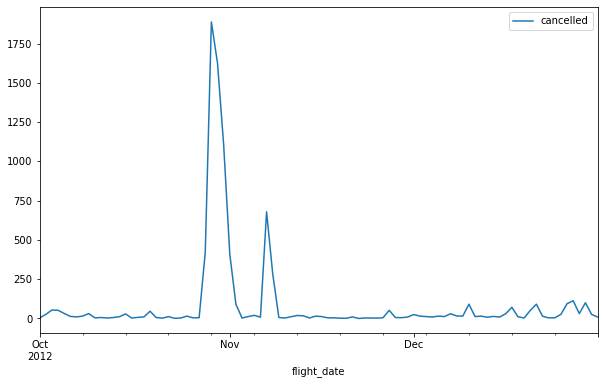

In [42]:
grouped_cancelled = flight_data[flight_data['flight_date'] >= '2012-10-01'].groupby('flight_date')[['cancelled']].sum()
grouped_cancelled.plot(figsize=(10,6))

In [46]:
flight_data.groupby('period_month').agg({'wspd': ['mean', 'min', 'max']})

wspd           
                   mean  min   max
period_month                      
2011-10       15.156535  4.7  32.4
2011-11       14.634273  2.5  31.7
2011-12       15.012097  2.2  32.4
2012-10       14.918710  2.5  58.3
2012-11       14.987723  1.4  37.1
2012-12       15.662376  1.4  41.0

In [47]:
# work in progress as fuck
r_cancelled = flight_data.groupby(['icao', 'period_month'])[['cancelled']].sum()
r_cancelled = r_cancelled.reset_index()
r_cancelled[r_cancelled['period_month'].dt.year == 2012]

,icao,period_month,cancelled
3,KBOS,2012-10,615
4,KBOS,2012-11,88
5,KBOS,2012-12,94
9,KEWR,2012-10,1260
10,KEWR,2012-11,507
11,KEWR,2012-12,266
15,KJFK,2012-10,752
16,KJFK,2012-11,251
17,KJFK,2012-12,60
21,KMIA,2012-10,206


## VISU

In [ ]:

# time_axes = 
col_list = ['tavg', 'wspd', 'prcp']

for col in col_list:
    fig, ax = plt.subplots(figsize=(10,6))

    # x = 
    # y = 

    sns.lineplot(x=weather_df_2011['time'], y=weather_df_2011[col], color='r', ci=None, ax=ax, label='2011')
    sns.lineplot(x=weather_df_2011['time'], y=weather_df_2012[col], color='b', ci=None, ax=ax, label='2012')
    
    ax.set_title(col.capitalize())
    #ax.legend()
    plt.show()

In [ ]:
column_list = weather_df.columns
for col in column_list[2:]:
    weather_df[weather_df['icao'] == 'TJSJ'].plot(kind='line', x='time', y=col, figsize=(8,6), rot=90)

In [ ]:
# good to work with temperature and windspeed
# maybe perspiration

column_list = ['tavg', 'wspd', 'prcp']
for col in column_list:
    weather_df[weather_df['icao'] == 'TJSJ'].plot(kind='line', x='time', y=col, figsize=(8,6), rot=90)

In [ ]:
display(stations_dict)
# create a list of airports ordered by the course of the hurricane
ordered_airports = ['TJSJ', 'KMIA', 'KPHL', 'KJFK', 'KEWR', 'KBOS']

In [ ]:
# plot only the average temperature for all airports
for airport in ordered_airports:
    weather_df[weather_df['icao'] == airport].plot(kind='line', x='time', y='wspd', figsize=(8,6), rot=90)

In [ ]:
# plot only the average temperature for all airports
for airport in ordered_airports:
    weather_df[weather_df['icao'] == airport].plot(kind='line', x='time', y='prcp', figsize=(8,6), rot=90)

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

In [73]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389158 entries, 0 to 389157
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   flight_date     389158 non-null  datetime64[ns]
 1   dep_time        379506 non-null  float64       
 2   sched_dep_time  389158 non-null  int64         
 3   dep_delay       379506 non-null  float64       
 4   arr_time        379210 non-null  float64       
 5   sched_arr_time  389158 non-null  int64         
 6   arr_delay       378602 non-null  float64       
 7   airline         389158 non-null  object        
 8   tail_number     386021 non-null  object        
 9   flight_number   389158 non-null  int64         
 10  origin          389158 non-null  object        
 11  dest            389158 non-null  object        
 12  air_time        378602 non-null  float64       
 13  distance        389158 non-null  float64       
 14  cancelled       389158 non-null  int

In [ ]:
results

In [74]:
corr = flight_data.corr()

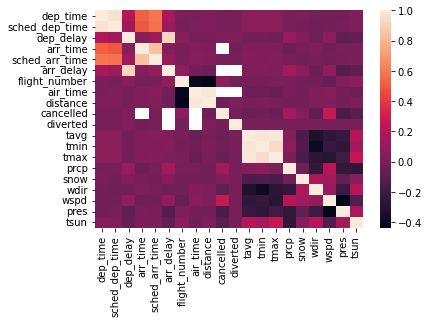

In [81]:
sns.heatmap(corr);

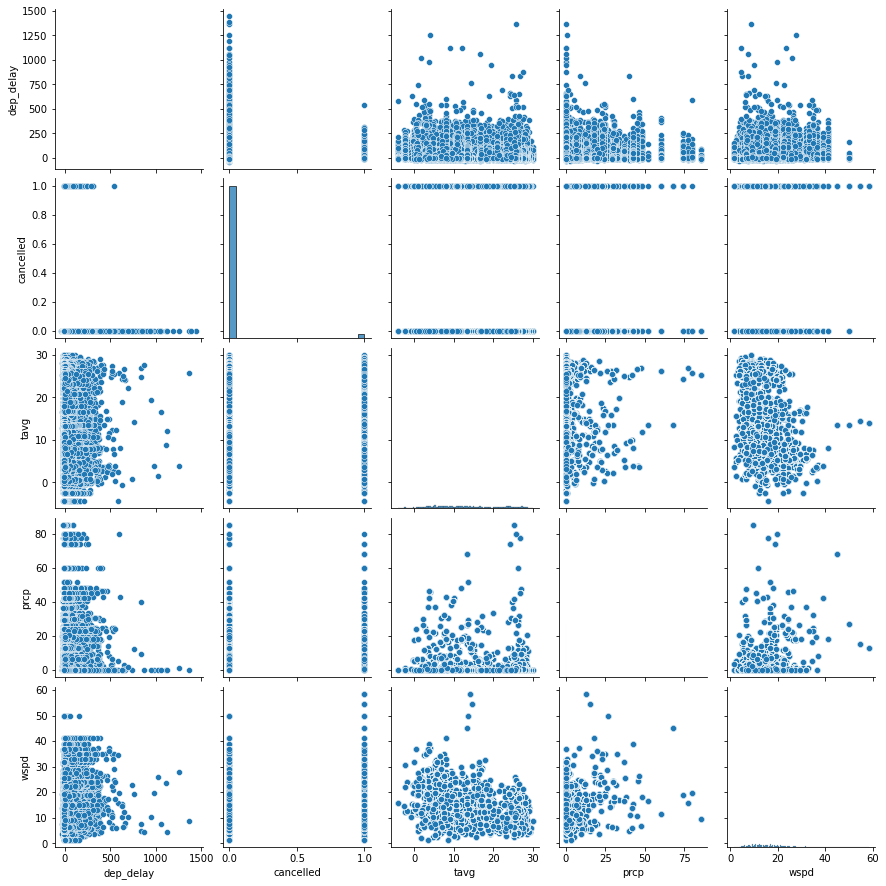

In [86]:
sns.pairplot(flight_data[['dep_delay', 'cancelled', 'tavg', 'prcp', 'wspd']])

In [96]:
data_sub = flight_data[(flight_data['flight_date'].dt.year == 2012) & (flight_data['flight_date'].dt.month == 10) & (flight_data['flight_date'].dt.day >= 20) & (flight_data['flight_date'].dt.day <= 26)]
smf.ols(formula='cancelled ~ wspd', data=data_sub).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cancelled   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.843
Date:                Mon, 08 Nov 2021   Prob (F-statistic):             0.0918
Time:                        20:45:31   Log-Likelihood:                 12465.
No. Observations:                8197   AIC:                        -2.493e+04
Df Residuals:                    8195   BIC:                        -2.491e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.001      0.335      0.738      -0.002       0.003
wspd           0.0002      0.000      1.686      0.092   -3.22e-05       0.000
==============================================================================
Omnibus:                    17340.784   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42596558.233
Skew:                          18.789   Prob(JB):                         0.00
Kurtosis:                     354.150   Cond. No.                         32.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
smf.ols(formula='cancelled ~ prcp', data=flight_data[(flight_data['flight_date'].dt.year == 2012) & (flight_data['flight_date'].dt.month == 10)]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cancelled   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     4018.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:42:51   Log-Likelihood:                -2568.2
No. Observations:               36334   AIC:                             5140.
Df Residuals:                   36332   BIC:                             5157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0415      0.002     27.595      0.000       0.039       0.044
prcp           0.0134      0.000     63.387      0.000       0.013       0.014
==============================================================================
Omnibus:                    19638.806   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116745.262
Skew:                           2.667   Prob(JB):                         0.00
Kurtosis:                       9.975   Cond. No.                         7.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""